# Company Bankruptcy Prediction (Kaggle) - Charles Lamb

# Table of Contents

### <a href='#week4'>Jump to Week 4</a>

<a href='#management'>Management Question</a>

<a href='#holdout'>Holdout Data Setup</a>

<a href='#capping'>EDA - Capping Outliers</a>

<a href='#correlation'>EDA - Feature to Feature Correlation</a>

<a href='#distribution'>EDA - Distribution of Independent Variables</a>

<a href='#scaling'>Standard Scaling</a>

<a href='#logistc'>Logisitc Regression</a>

<a href='#bayes'>Naive Bayes Model</a>

<a href='#svm_linear'>SVM - Linear Kernel</a>

<a href='#svm_poly'>SVM - Poly Kernal</a>

<a href='#svm_rbf'>SVM - RBF Kernel</a>

### <a href='#week5'>Jump to Week 5</a>

<a href='#forest'>Random Forest Classifier - Default Assumptions</a>

<a href='#forest_hypertuned'>Random Forest Classifier - Hypertuned</a>

<a href='#gboost'>Gradient Boosted Trees - Default Assumptions</a>

<a href='#hgboost'>Gradient Boosted Trees - Hypertuned</a>

<a href='#etrees'>Extra Trees - Default Assumptions</a>

<a href='#hetrees'>Extra Trees - Hypertuned</a>

<a href='#kaggle'>Note on Kaggle Submission</a>

# Week 4 <a id=’week4’></a>

### Imports and Data Load

In [1]:
#library installs:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
#orginal datasource at this location: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?resource=download
df = pd.read_csv('data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### Looking at variables and shape of data

In [3]:
df.shape

(6819, 96)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [5]:
#removing the '?' in the bankrupt column to faciliate easier manipulation
df = df.rename(columns={'Bankrupt?':'Bankrupt'})

In [6]:
#checking that bankrupt is binary.  and how many instances of bankruptcy are in the data
df.groupby(['Bankrupt'])['Bankrupt'].count()

Bankrupt
0    6599
1     220
Name: Bankrupt, dtype: int64

### Modifying Column Names

<font color='red'> The column names of the database are a little annoying.  We observe that the indepedent variables have an empty space at the beginning of their name.  We also observe that many of the variables are multiple words </font>

<font color='red'> I delete the inital space at the beginning of the column name and replace remaining spaces with an underscore </font>

In [7]:
df.columns = df.columns.str.replace(' ', '_')

In [8]:
orig_columns = df.columns.to_list()

In [9]:
new_columns = []
for i in range(len(orig_columns)):
    new_columns.append(orig_columns[i][1:])
#fixing the first column since that will not have an underscore
new_columns[0] = 'Bankrupt'

In [10]:
df.columns = new_columns

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt                                                 6819 non-null   int64  
 1   ROA(C)_before_interest_and_depreciation_before_interest  6819 non-null   float64
 2   ROA(A)_before_interest_and_%_after_tax                   6819 non-null   float64
 3   ROA(B)_before_interest_and_depreciation_after_tax        6819 non-null   float64
 4   Operating_Gross_Margin                                   6819 non-null   float64
 5   Realized_Sales_Gross_Margin                              6819 non-null   float64
 6   Operating_Profit_Rate                                    6819 non-null   float64
 7   Pre-tax_net_Interest_Rate                                6819 non-null   float64
 8   After-tax_net_Interest_Rate 

### Missing data

<font color='red'> We have data for 6819 companies.  From .info() it appears all data fields are fully populated.  Lets just double check that though </font>

In [12]:
#double checking no null values
df.isna().sum().sum()

0

### Descriptive Statistics for Data Elements

In [13]:
stats = df.describe(include = 'all')
stats

,Bankrupt,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,...,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Net_Income_Flag,Equity_to_Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


### Zeros in Data

<font color='red'> Almost all of these fields have 0 values.  Looking into those bit more.  Want to understand if 0 is a legitamte value or if nulls were replaced by zeros </font>

<font color='red'> Just looking at distribution of a randomly choosen varaibles as an example </font>

<AxesSubplot:xlabel='Operating_Gross_Margin', ylabel='Count'>

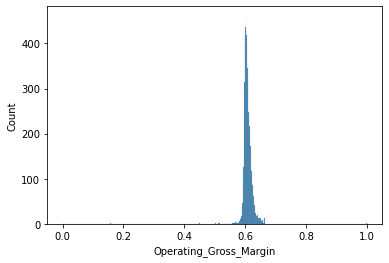

In [14]:
sns.histplot(data=df.Operating_Gross_Margin)

<font color='red'> Not a big point mass at 0 so thats promising.  Let's look at some of the individual values where gross margin is 0 </font>

In [15]:
df[df['Operating_Gross_Margin'] == 0]

,Bankrupt,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,...,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Net_Income_Flag,Equity_to_Liability
2490,0,0.412178,0.47427,0.457733,0.0,0.0,0.988045,0.784312,0.796607,0.303526,...,0.766285,0.002466,0.626786,0.0,0.838652,0.274813,0.026789,0.565148,1,0.743588


<font color='red'> kind of wierd.  the implacation here is that the ratio of gross margin to sales is 0.  That either means margin is 0 or sales is 0 </font>

In [16]:
df[df['Operating_Gross_Margin'] == 0].Cash_Flow_to_Sales

2490    0.670041
Name: Cash_Flow_to_Sales, dtype: float64

<font color='red'> cash flow to sales is non-zero though, so the implication is gross margin is 0</font>

<font color='red'> gross margin is revenue less cost of goods sold.  i dont have sufficient info to determine the companies cost of good sold, but it seems unlikley the company is making no gross margin so this is likley a data error</font>

In [17]:
for col in df.columns:
    cols = df[col]
    count = (cols ==0).sum()
    print('Zero count in column',col,' is:',count)

Zero count in column Bankrupt  is: 6599
Zero count in column ROA(C)_before_interest_and_depreciation_before_interest  is: 1
Zero count in column ROA(A)_before_interest_and_%_after_tax  is: 1
Zero count in column ROA(B)_before_interest_and_depreciation_after_tax  is: 1
Zero count in column Operating_Gross_Margin  is: 1
Zero count in column Realized_Sales_Gross_Margin  is: 1
Zero count in column Operating_Profit_Rate  is: 1
Zero count in column Pre-tax_net_Interest_Rate  is: 1
Zero count in column After-tax_net_Interest_Rate  is: 1
Zero count in column Non-industry_income_and_expenditure/revenue  is: 1
Zero count in column Continuous_interest_rate_(after_tax)  is: 1
Zero count in column Operating_Expense_Rate  is: 1
Zero count in column Research_and_development_expense_rate  is: 1424
Zero count in column Cash_flow_rate  is: 1
Zero count in column Interest-bearing_debt_interest_rate  is: 891
Zero count in column Tax_rate_(A)  is: 2568
Zero count in column Net_Value_Per_Share_(B)  is: 1
Ze

<font color='red'> it appears to be pretty seldom when values are 0 so it wont have much impact on our model.  there are a few fields where there are a significant number of 0s, but these seem legit.  for instance, long-term liabilities to current assets.  this could easily be 0 if the organization does not have any long-term debt</font>

<a id='capping'></a>
### Outliers

<font color='red'> from the descriptive statistics we noticed that some variables appear to have very large values when we expect a ratio between 0 and 1.  lets see if these are outliers.  looking at an example first: current ratio</font>

<AxesSubplot:xlabel='Current_Ratio'>

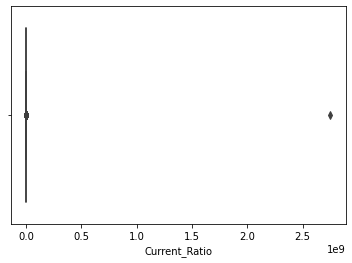

In [18]:
 sns.boxplot(x='Current_Ratio', data=df)

In [19]:
df[df['Current_Ratio'] > 1].Current_Ratio

2499    2.750000e+09
Name: Current_Ratio, dtype: float64

<font color='red'> Current Ratio is short term assets / short term liabilities.  so it is possible that for a company with very little short term liabilities we get a very high current ratio.  in that sense this is not truely an outlier but we should probably cap values like this </font>

<font color='red'> the question is should we do this for other values as well?  looking at number of observations above 1 on other variables </font>

In [20]:
cap_list = []
for col in df.columns:
    cols = df[col]
    count = (cols > 1).sum()
    if count > 0:
        print('Observations above 1.0 in column',col,' is:',count,' and % of observations is:',round(count/df.shape[0],2))
        if count/df.shape[0] < .10:
            cap_list.append(col)

Observations above 1.0 in column Operating_Expense_Rate  is: 2282  and % of observations is: 0.33
Observations above 1.0 in column Research_and_development_expense_rate  is: 4033  and % of observations is: 0.59
Observations above 1.0 in column Interest-bearing_debt_interest_rate  is: 221  and % of observations is: 0.03
Observations above 1.0 in column Revenue_Per_Share_(Yuan_¥)  is: 5  and % of observations is: 0.0
Observations above 1.0 in column Total_Asset_Growth_Rate  is: 6017  and % of observations is: 0.88
Observations above 1.0 in column Net_Value_Growth_Rate  is: 2  and % of observations is: 0.0
Observations above 1.0 in column Current_Ratio  is: 1  and % of observations is: 0.0
Observations above 1.0 in column Quick_Ratio  is: 9  and % of observations is: 0.0
Observations above 1.0 in column Total_debt/Total_net_worth  is: 8  and % of observations is: 0.0
Observations above 1.0 in column Accounts_Receivable_Turnover  is: 22  and % of observations is: 0.0
Observations above 1.0

<font color='red'> where it is uncommon for the ratio to be above 1 (measured as less than 10% of observations have values below 1), i will cap the metric at 1 </font>

In [21]:
print(df.shape)
for i in cap_list:
    df[i]= np.clip(df[i],a_max=1,a_min=None)
print(df.shape)

(6819, 96)
(6819, 96)


<font color='red'> checking that this capping solved our problem</font>

In [22]:
df['Current_Ratio'].describe()

count    6819.000000
mean        0.015251
std         0.026446
min         0.000000
25%         0.007555
50%         0.010587
75%         0.016270
max         1.000000
Name: Current_Ratio, dtype: float64

In [23]:
#breaking apart variables to make the graphing more legible
col_list = df.columns.to_list()
col_list_30 = col_list[:30]
col_list_60 = col_list[30:60]
col_list_90 = col_list[60:]

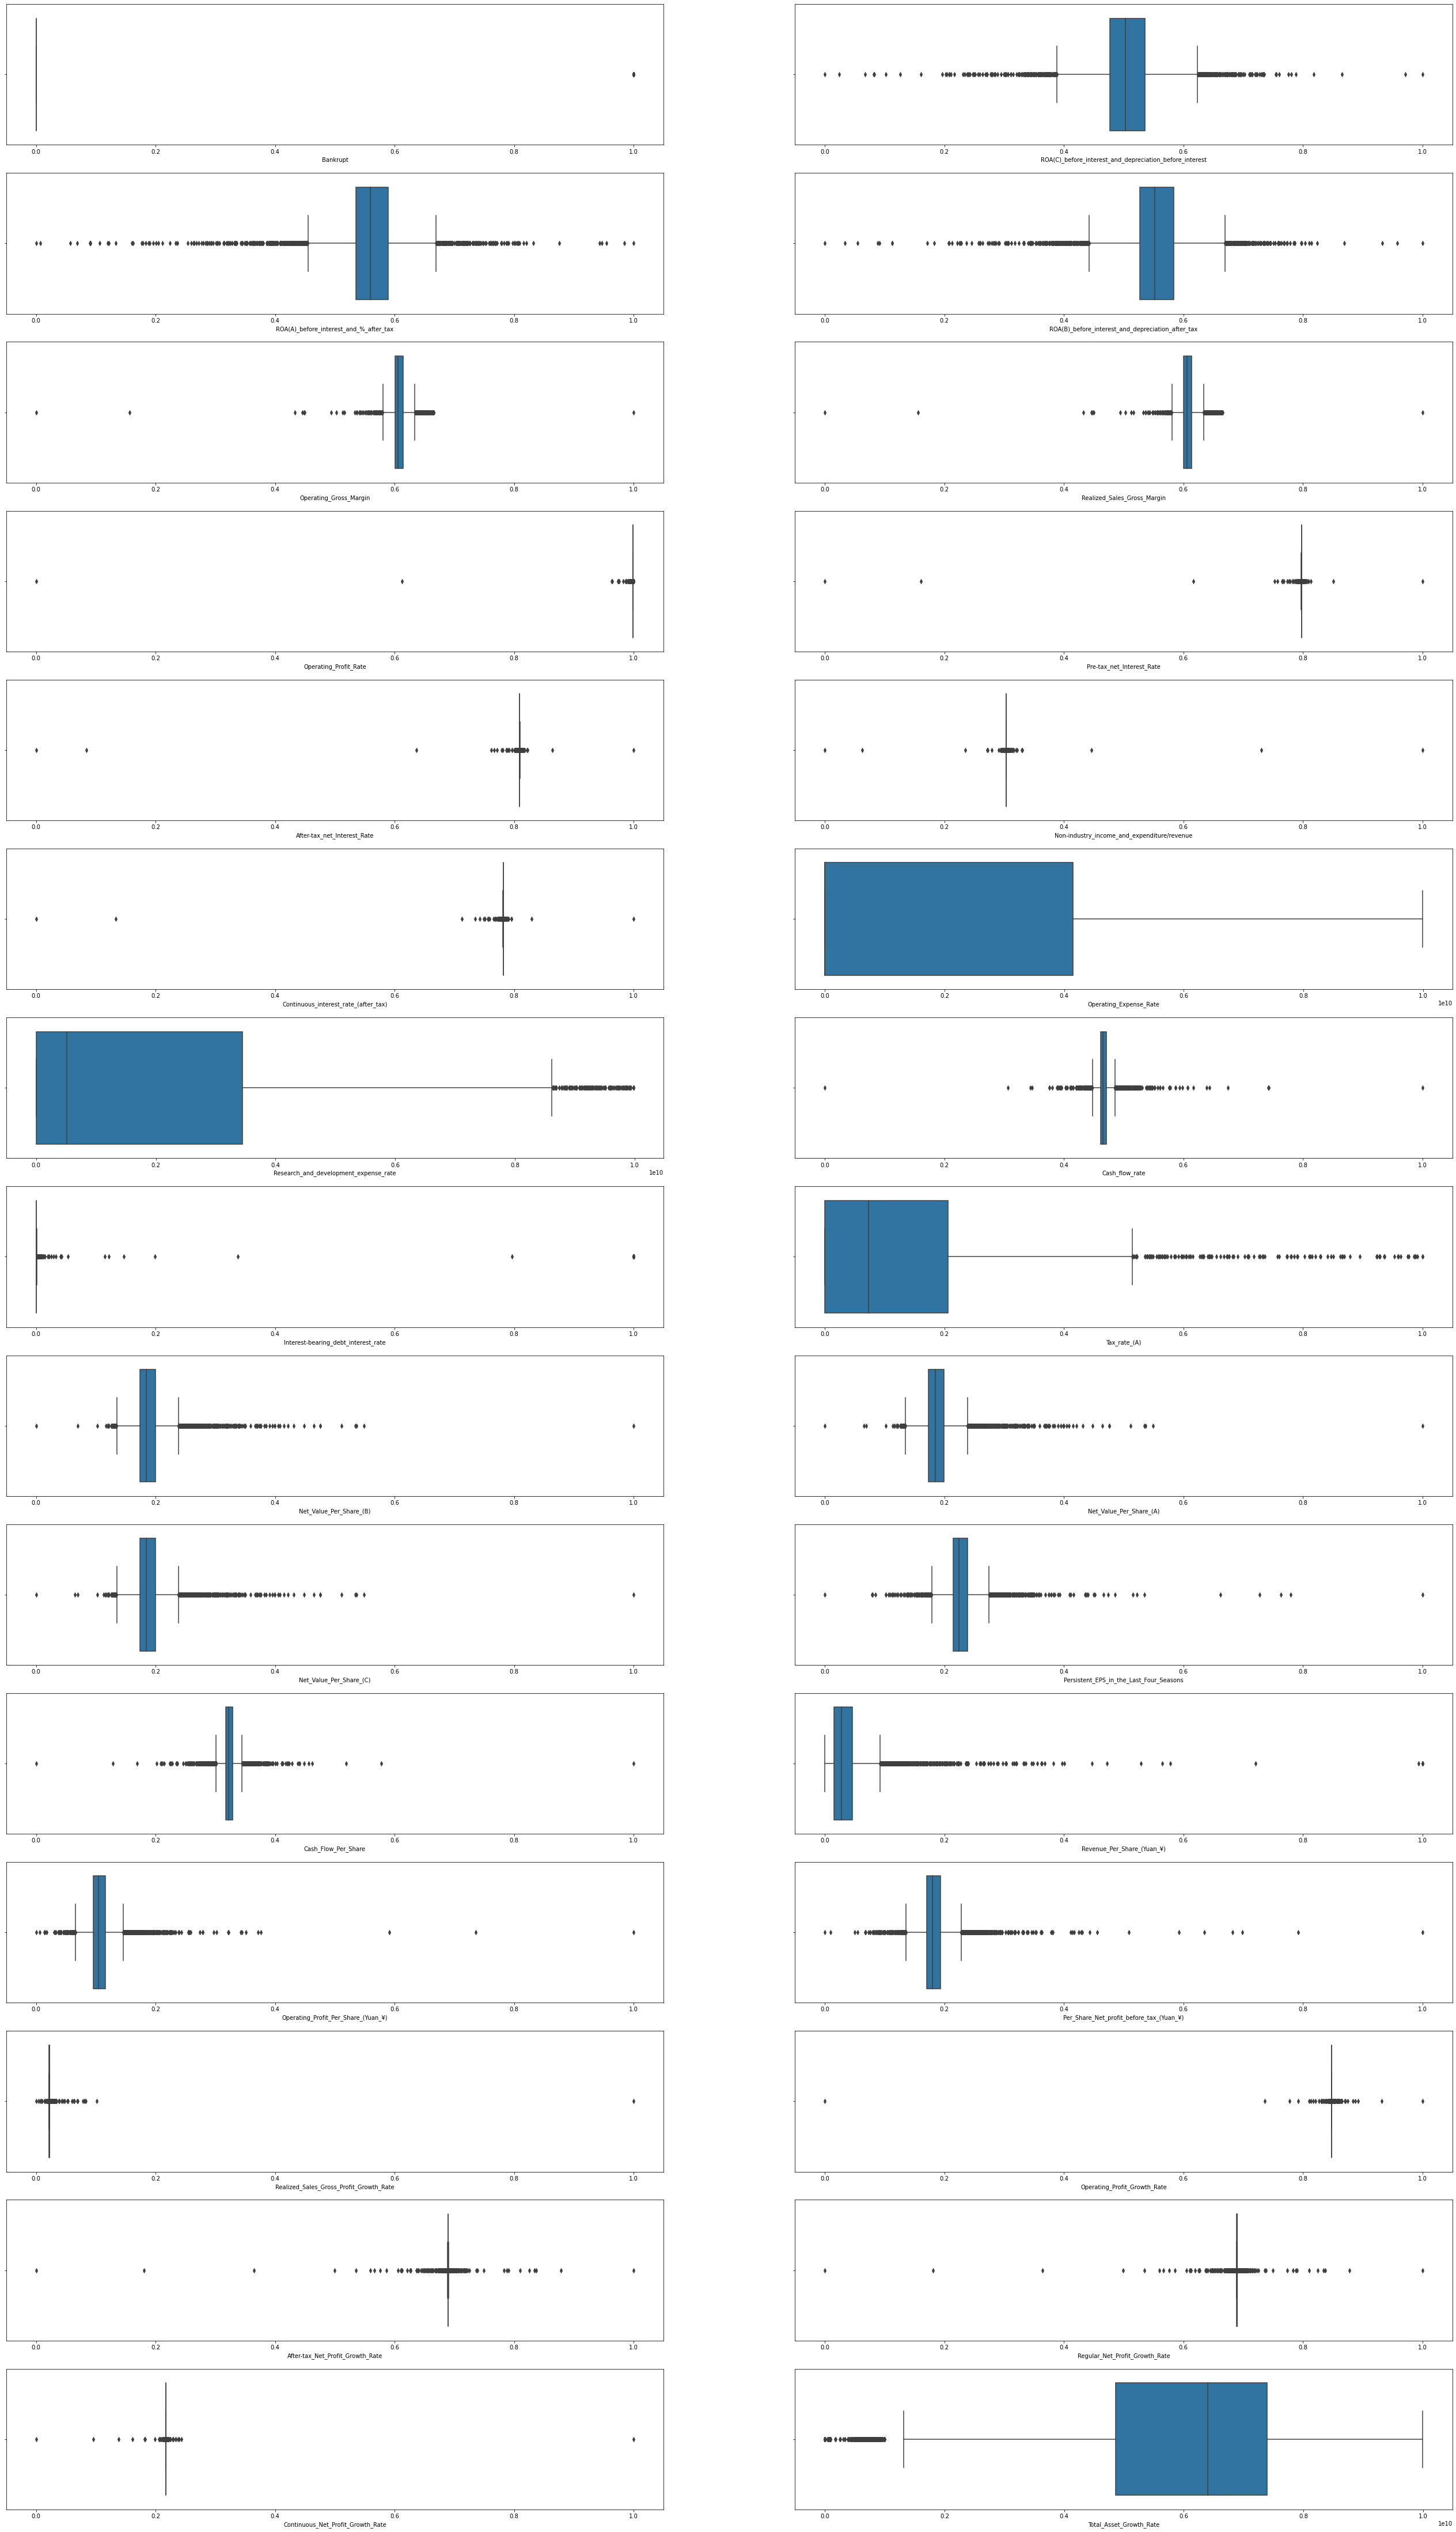

In [24]:
fig, axes = plt.subplots(round(len(col_list_30) / 2), 2,figsize = (45, 80))

for i, ax in enumerate(fig.axes):
    if i < len(df.columns) - 1:
        sns.boxplot(x=col_list_30[i], data=df, ax=ax)

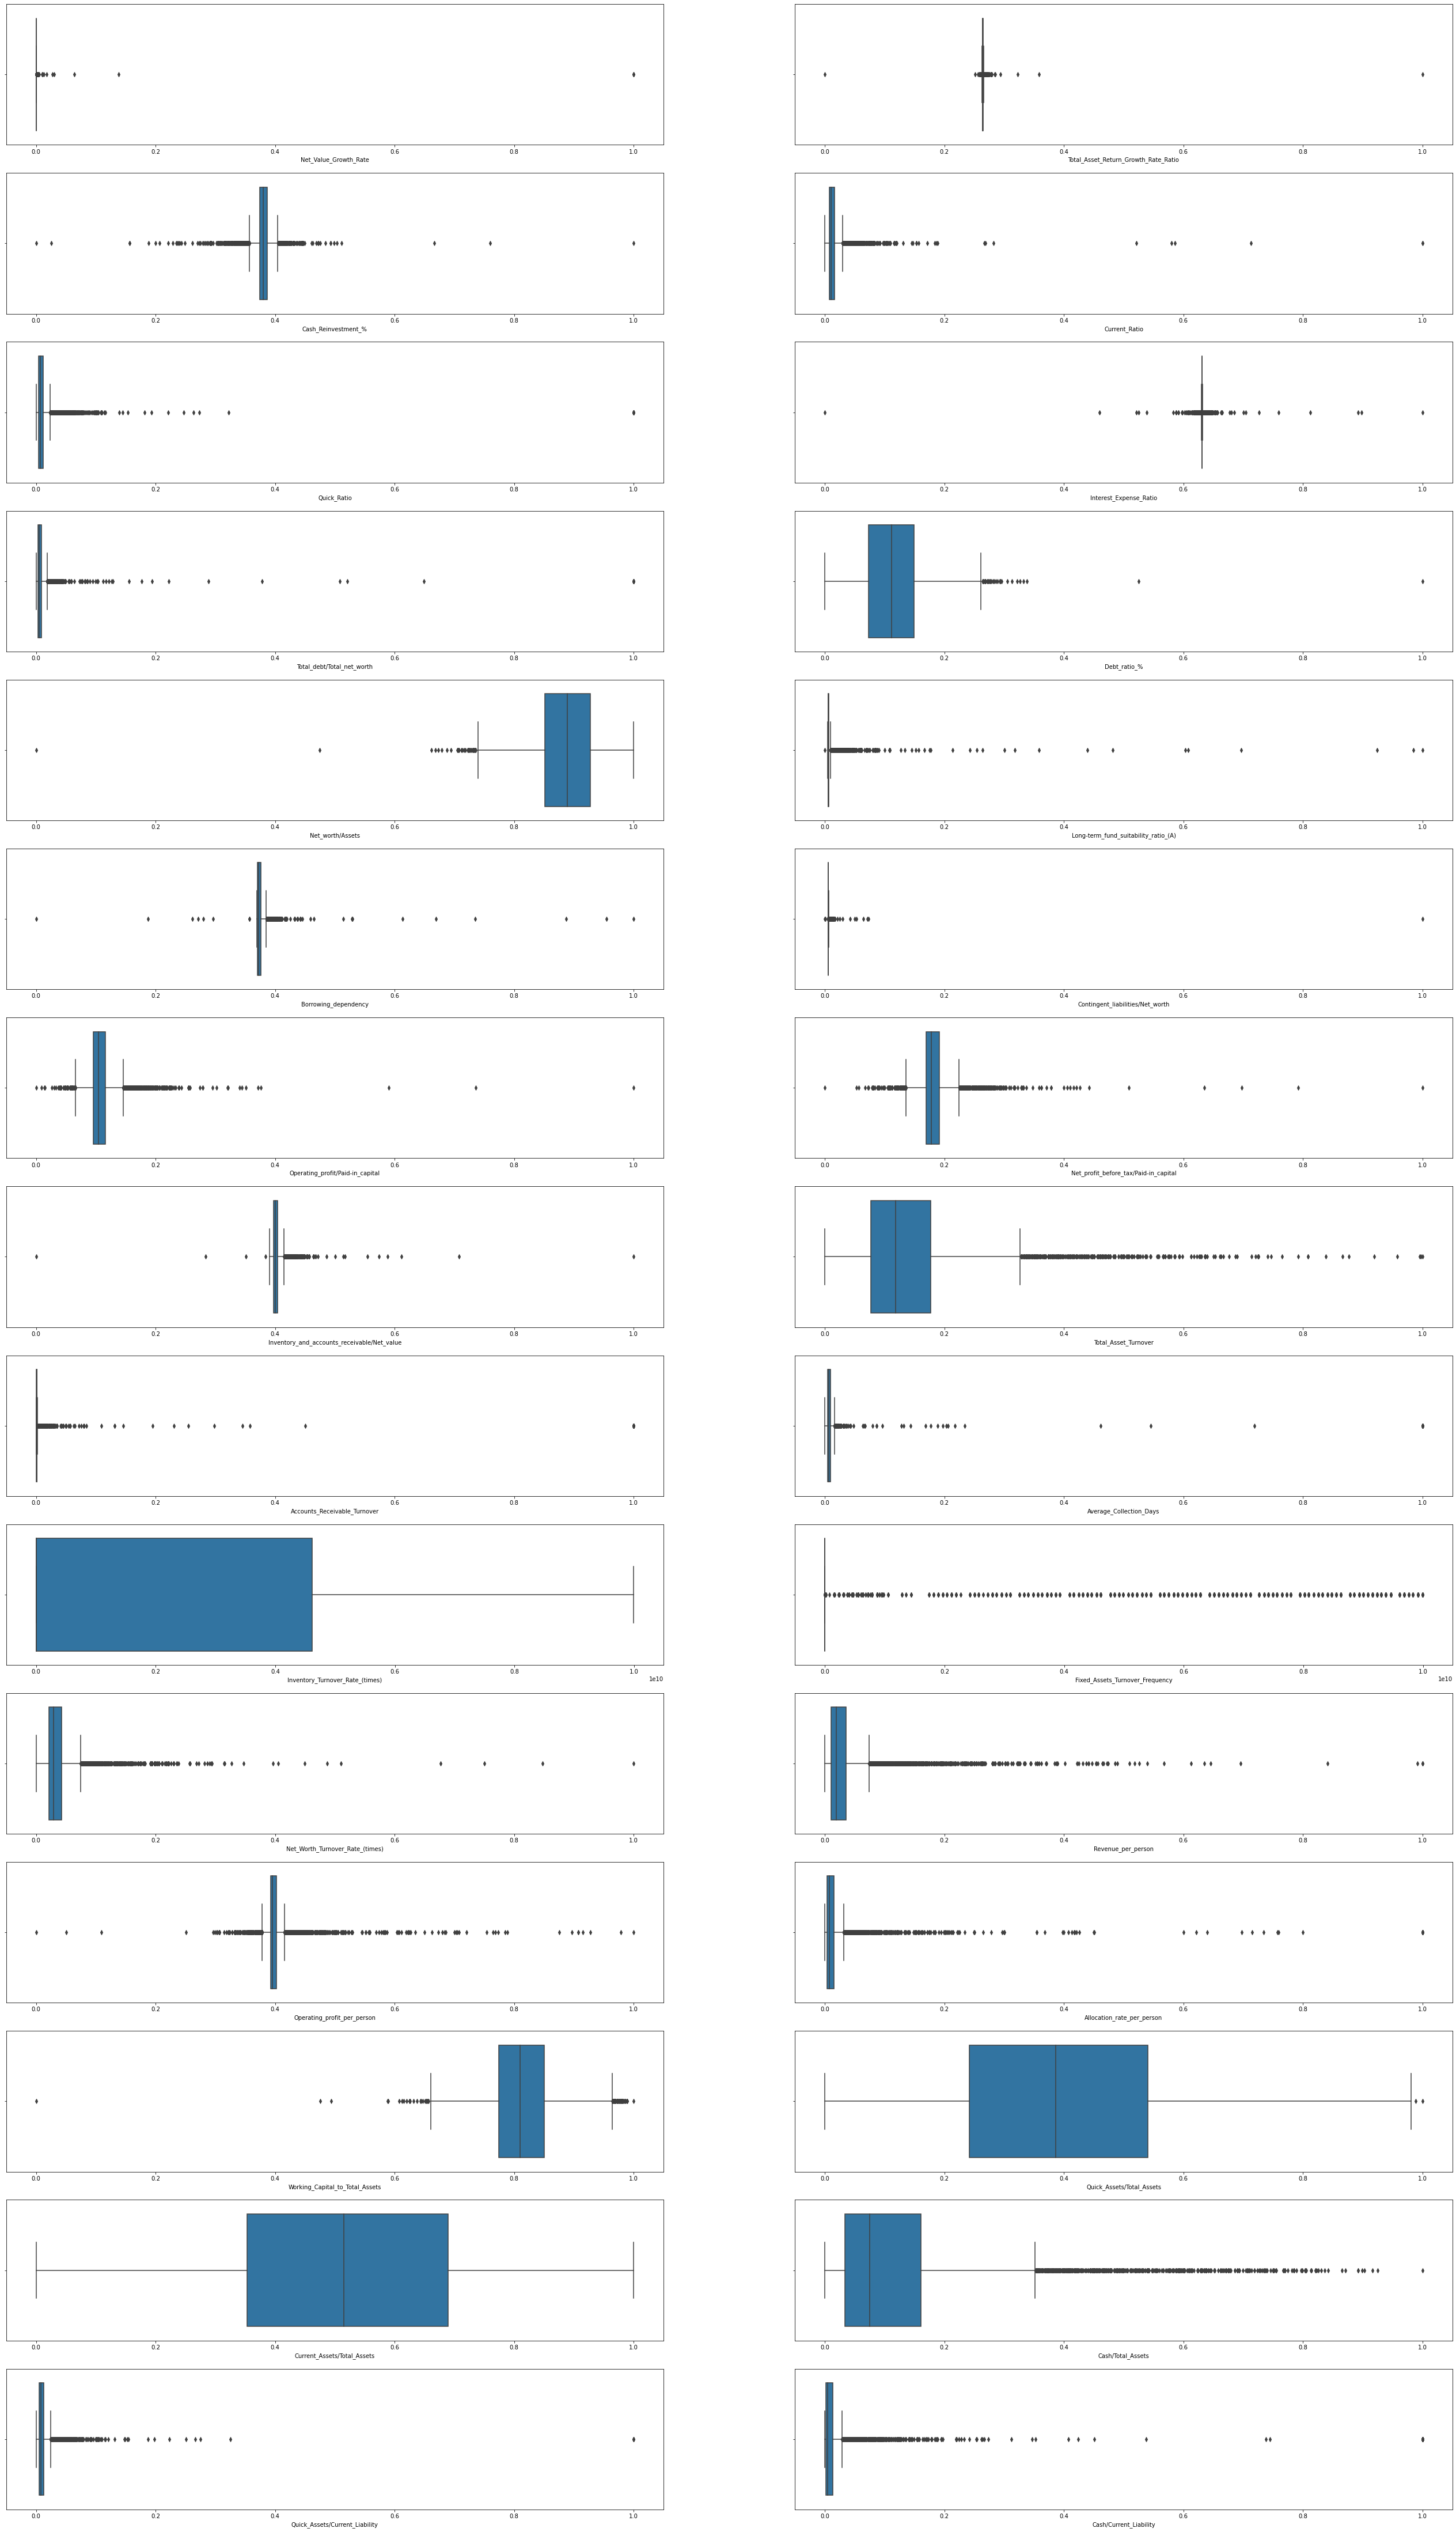

In [25]:
fig, axes = plt.subplots(round(len(col_list_60) / 2), 2,figsize = (45, 80))

for i, ax in enumerate(fig.axes):
    if i < len(df.columns) - 1:
        sns.boxplot(x=col_list_60[i], data=df, ax=ax)

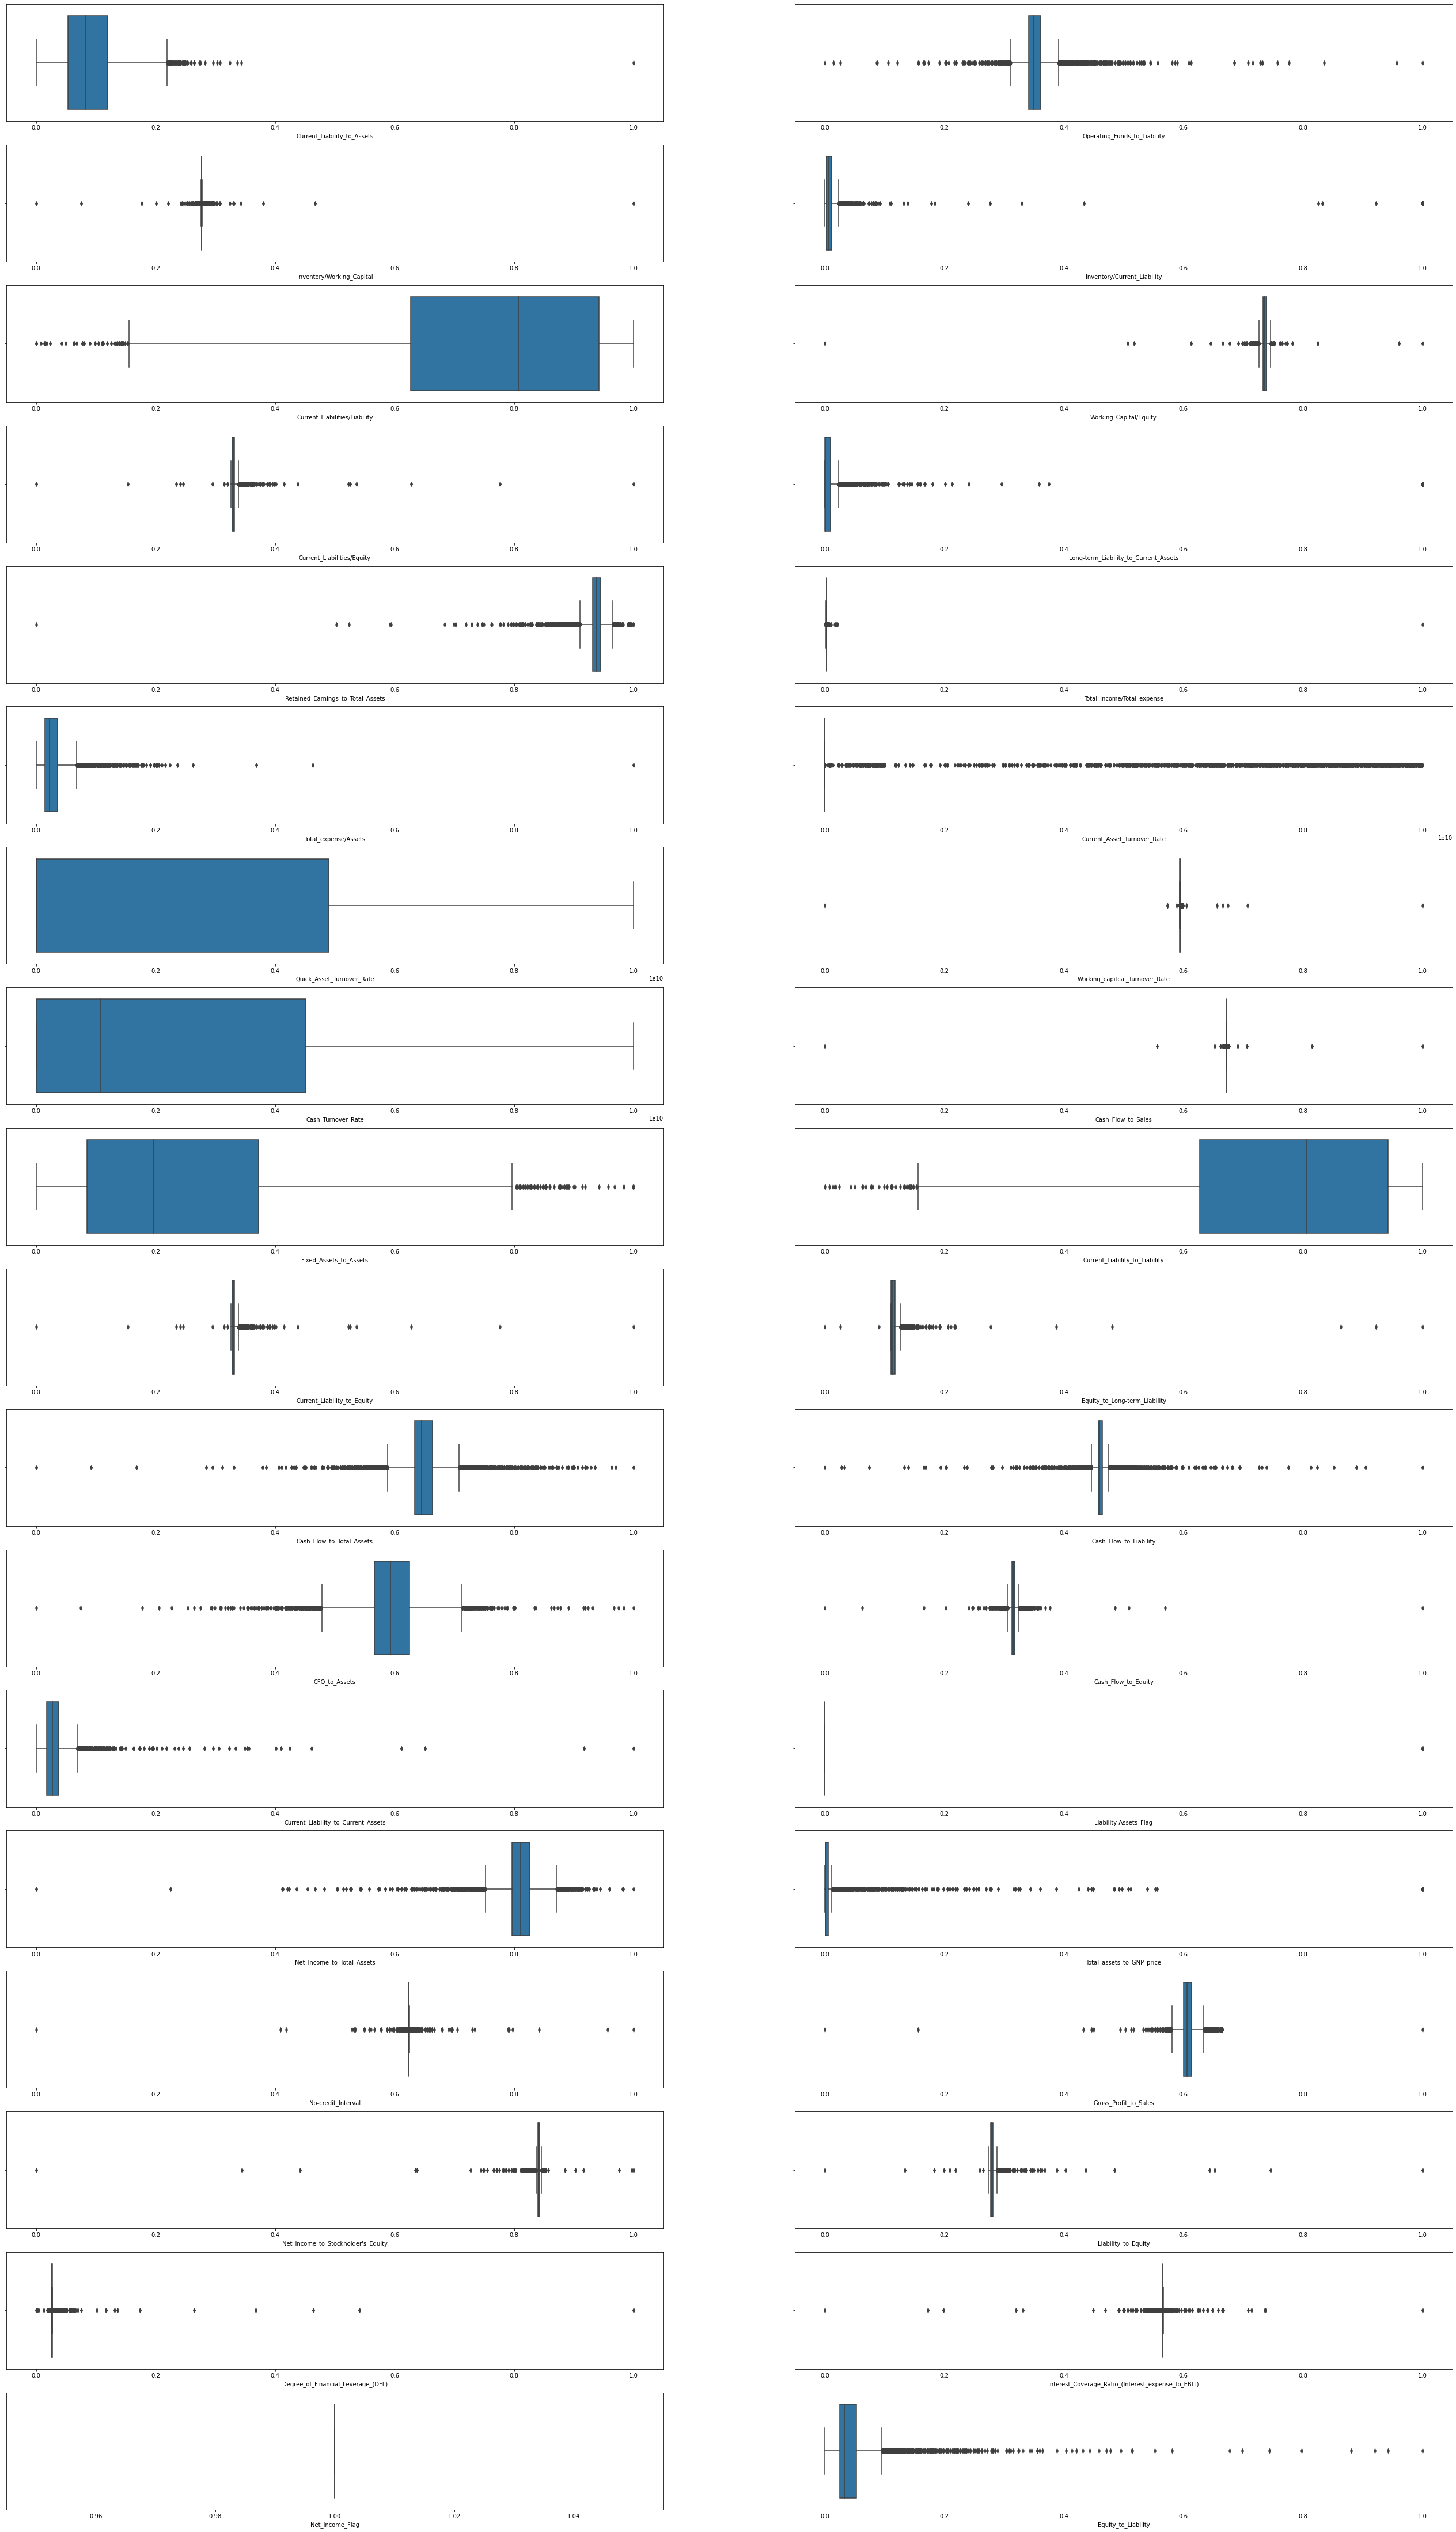

In [26]:
fig, axes = plt.subplots(round(len(col_list_90) / 2), 2,figsize = (45, 80))

for i, ax in enumerate(fig.axes):
    if i < len(df.columns) - 1:
        sns.boxplot(x=col_list_90[i], data=df, ax=ax)

<font color='red'> the boxplot shows a large number of outliers, but as with the current ratio we expect many of these are accurate data points.  other than the capping previously performed we retain the data as is</font>

### Flag Data

<font color='red'> we observe from the boxplots a few binary flags: Net_Income_Flag and Liability_Assets_Flag.  Lets dig into this a bit</font>

In [27]:
df.groupby(['Net_Income_Flag'])['Net_Income_Flag'].count()

Net_Income_Flag
1    6819
Name: Net_Income_Flag, dtype: int64

In [28]:
#all observations have the same value for net_income_flag so we drop it
print(df.shape)
col_drop = ['Net_Income_Flag']
df = df.drop(columns=col_drop)
print(df.shape)

(6819, 96)
(6819, 95)


In [29]:
df.groupby(['Liability-Assets_Flag'])['Liability-Assets_Flag'].count()

Liability-Assets_Flag
0    6811
1       8
Name: Liability-Assets_Flag, dtype: int64

<font color='red'> We drop the Net Income Flag as all observations had the same value.  Retain the Liability Asset Flag.</font>

<a id='correlation'></a>
### Independent Variable Correlation

<font color='red'> Since there are so many indepedent variables here, I prefer to look at the correlation matrix as opposed to a graphic</font>

In [30]:
corr = df.drop('Bankrupt', axis=1).corr()
out = corr[(corr >= 0.5) | (corr <= -0.5)]
out

,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,Continuous_interest_rate_(after_tax),...,Liability-Assets_Flag,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Equity_to_Liability
ROA(C)_before_interest_and_depreciation_before_interest,1.000000,0.940124,0.986849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.887670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROA(A)_before_interest_and_%_after_tax,0.940124,1.000000,0.955741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.961552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROA(B)_before_interest_and_depreciation_after_tax,0.986849,0.955741,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.912040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating_Gross_Margin,NaN,NaN,NaN,1.000000,0.999518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Realized_Sales_Gross_Margin,NaN,NaN,NaN,0.999518,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.999518,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Net_Income_to_Stockholder's_Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,-0.791836,NaN,NaN,NaN
Liability_to_Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.791836,1.000000,NaN,NaN,NaN
Degree_of_Financial_Leverage_(DFL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Interest_Coverage_Ratio_(Interest_expense_to_EBIT),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


<font color='red'> We expect many of these independent variables to be strongly related as many of these financial metrics are measuring related items
    
    
</font>

We observe and treat the following:
- Operating and Sales Gross Margin are nearly perfectly correlated: since they measure very similiar metrics we drop sales gross margin
- Gross Margin is also nearly perfectly correcated with Gross profit to sales.  These are the same metrics with different names:  Drop Gross Profit to Sales
- There pre, post, and continuous tax interest rates are highly correlated and we have a seperate variable for tax rate.  Drop after-tax net interest rate and continuous interest rate
- Net value per share are perfectly correlated.  And nearly identically distributed per parplot below.  We delete the B and C share net value metrics
- Deleting after-tax net profit growth as perfectly correlated with regular net profit growth
- Deleting debt_ratio as it is the reciprocal of net worth/assets
- Current Liabilities / liabilities appears in the data twice, drop the duplicate (Current_Liability_to_Liability and Current_Liabilities/Liability)
- Same thing with Current_Liabilities/Equity, drop the duplicate (Current_Liabilities/Equity and Current_Liability_to_Equity)

</font>

In [31]:
drop_list = ['Realized_Sales_Gross_Margin','Gross_Profit_to_Sales','After-tax_net_Interest_Rate','Continuous_interest_rate_(after_tax)','Net_Value_Per_Share_(B)','Net_Value_Per_Share_(C)','After-tax_Net_Profit_Growth_Rate','Debt_ratio_%','Current_Liabilities/Liability','Current_Liability_to_Equity']
df2 = df.drop(columns=drop_list)

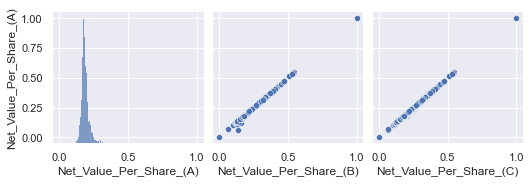

In [32]:
#confirming net value per share metrics are nearly identical
plot = ['Net_Value_Per_Share_(A)','Net_Value_Per_Share_(B)','Net_Value_Per_Share_(C)']
df_plot = df[plot]
sns.set(font_scale=1)
for i in range(0, len(df_plot.columns), 5):
    sns.pairplot(data=df_plot,
                x_vars=df_plot.columns[i:i+5],
                y_vars=['Net_Value_Per_Share_(A)'])

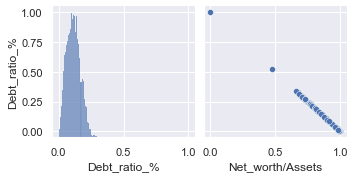

In [33]:
#confirming debt ratio and net worth are recipricals of each other
plot = ['Debt_ratio_%','Net_worth/Assets']
df_plot = df[plot]
sns.set(font_scale=1)
for i in range(0, len(df_plot.columns), 5):
    sns.pairplot(data=df_plot,
                x_vars=df_plot.columns[i:i+5],
                y_vars=['Debt_ratio_%'])

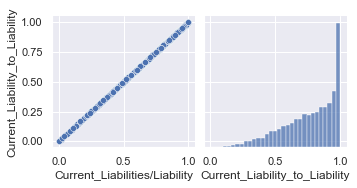

In [34]:
#seems like current liability/liability is duplicated 
plot = ['Current_Liabilities/Liability','Current_Liability_to_Liability']
df_plot = df[plot]
sns.set(font_scale=1)
for i in range(0, len(df_plot.columns), 5):
    sns.pairplot(data=df_plot,
                x_vars=df_plot.columns[i:i+5],
                y_vars=['Current_Liability_to_Liability'])

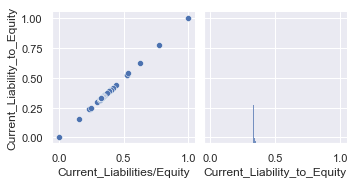

In [35]:
#seems like current Current_Liabilities/Equity is duplicated
plot = ['Current_Liabilities/Equity','Current_Liability_to_Equity']
df_plot = df[plot]
sns.set(font_scale=1)
for i in range(0, len(df_plot.columns), 5):
    sns.pairplot(data=df_plot,
                x_vars=df_plot.columns[i:i+5],
                y_vars=['Current_Liability_to_Equity'])

<a id='distribution'></a>
### Distribution of Independent Variables

In [36]:
full_list = df2.columns.to_list()
len(full_list)

85

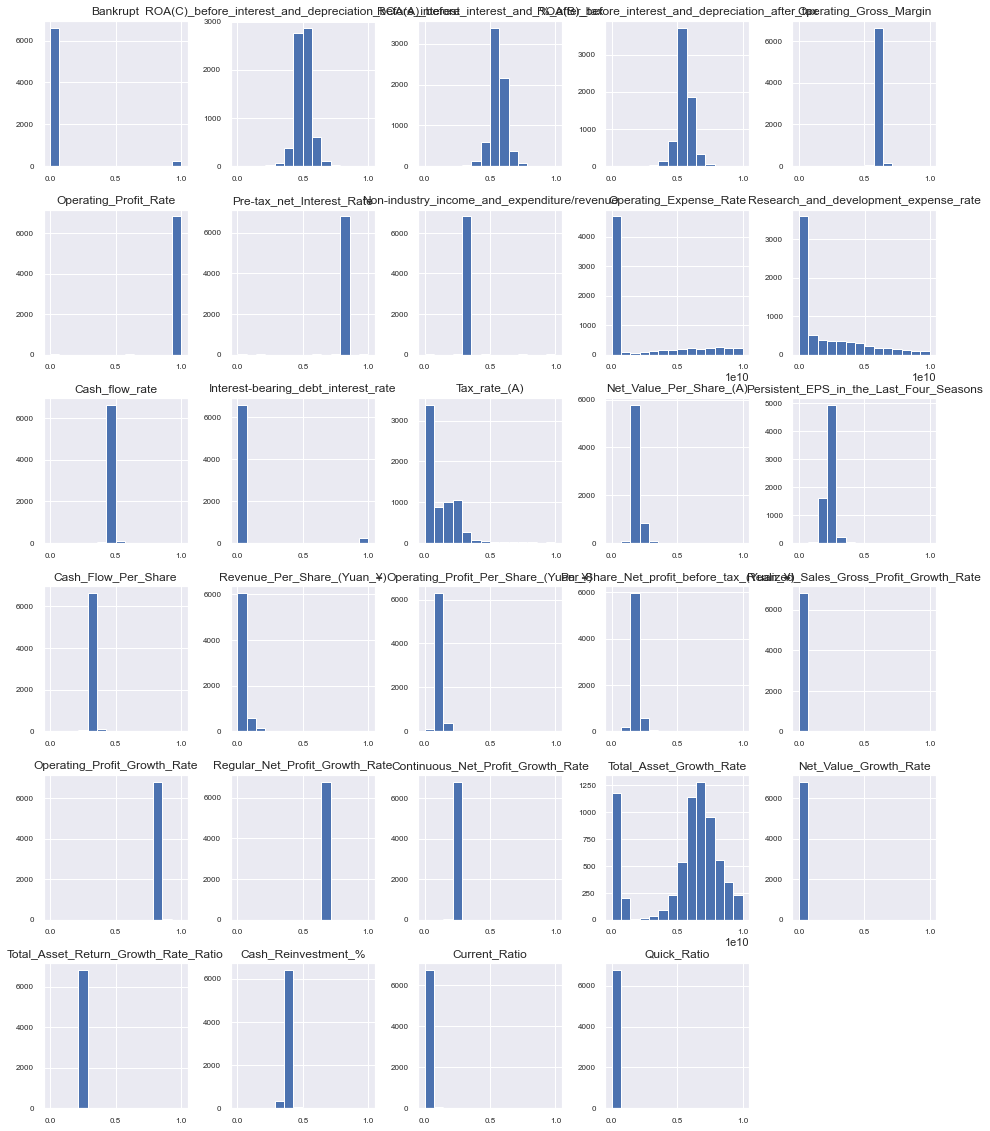

In [37]:
df_plot = df2[full_list[0:29]]
df_plot.hist(figsize=(16, 20), bins=14, xlabelsize=8, ylabelsize=8); 

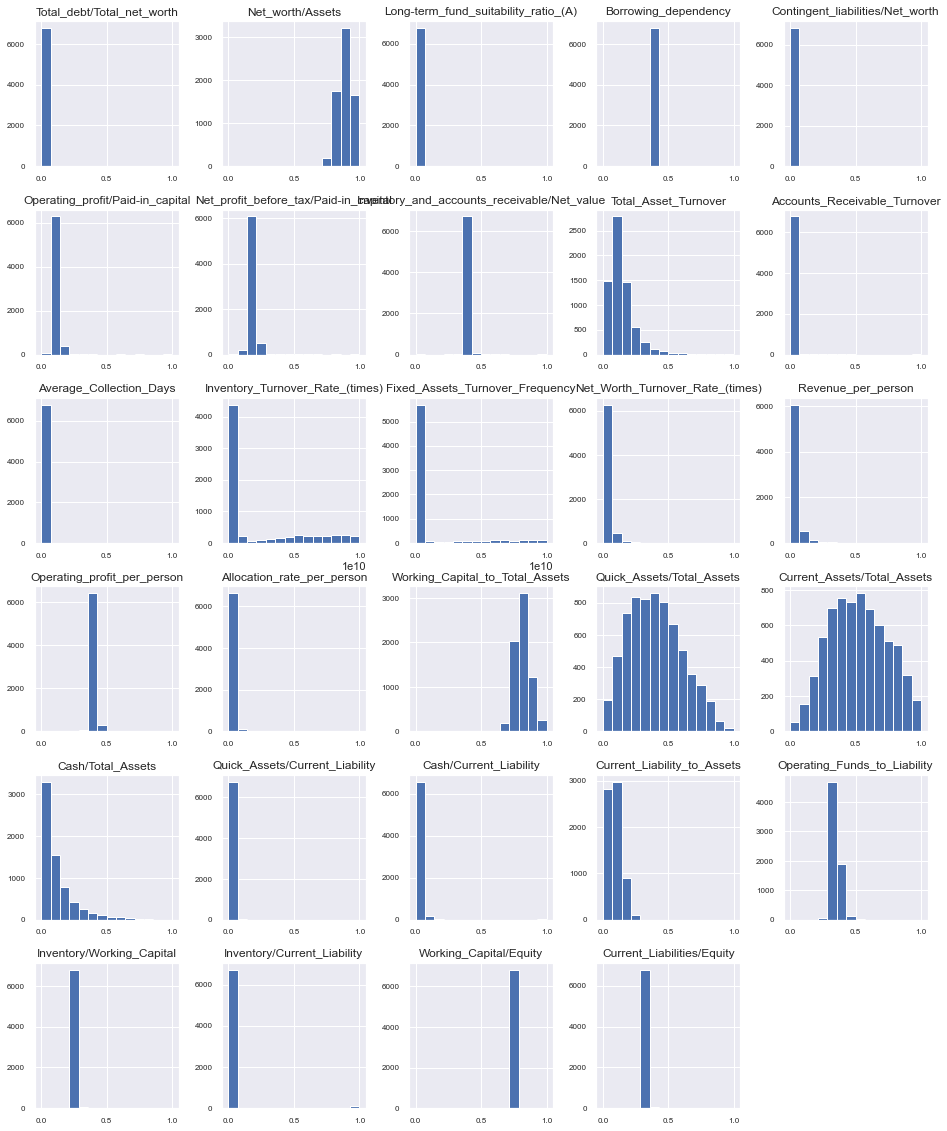

In [38]:
df_plot = df2[full_list[30:59]]
df_plot.hist(figsize=(16, 20), bins=14, xlabelsize=8, ylabelsize=8); 

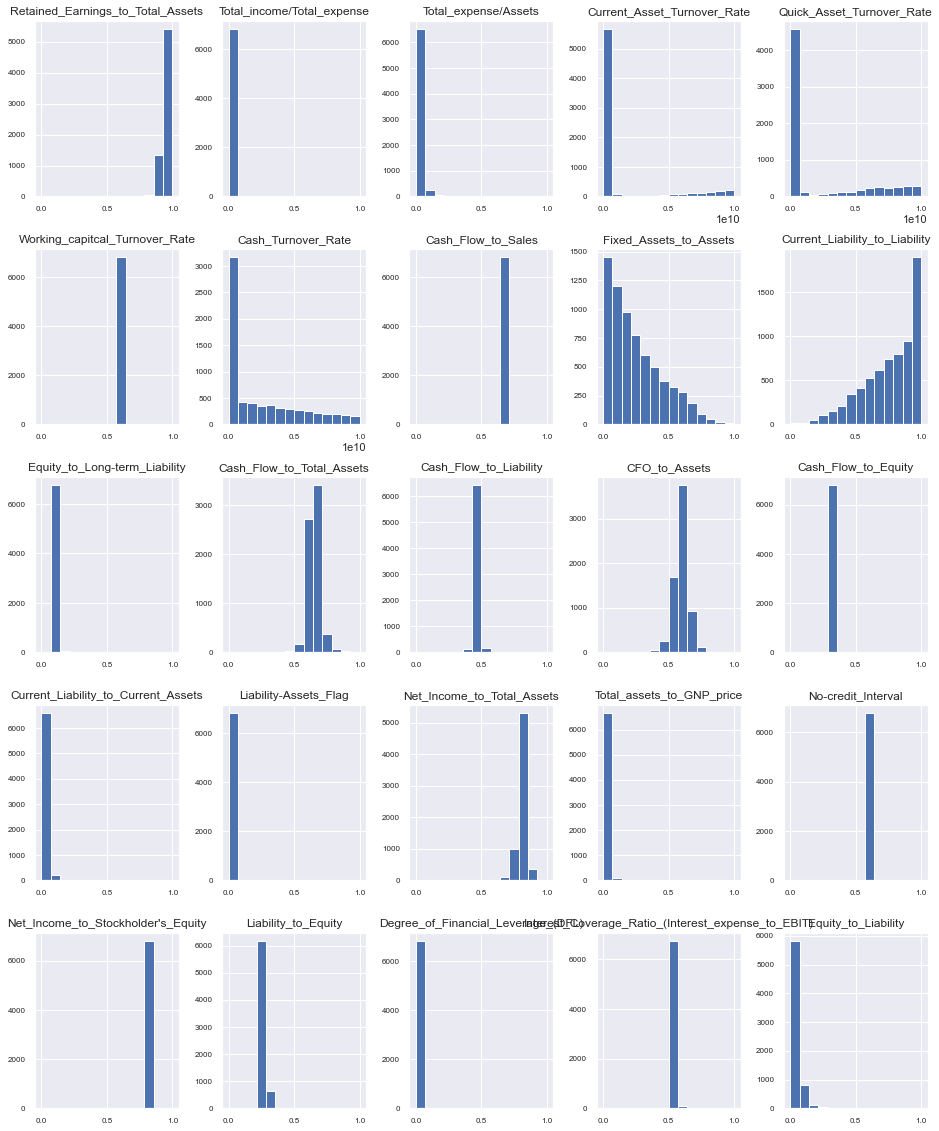

In [39]:
df_plot = df2[full_list[60:]]
df_plot.hist(figsize=(16, 20), bins=14, xlabelsize=8, ylabelsize=8); 

<font color='red'>We observe that the distribution of many variables is close to a point mass.  This is somewhat exacerbated by the low number of bins in these histograms.  However it does imply a very narrow variance on some of these variables.  We may want to consider standard scaling given the narrow variance of most of these indepedent variables    </font>

<a id='scaling'></a>
### Standard Scaling

In [40]:
#standard_scaling all numerical variables
df_standard = df2.select_dtypes(include = ['float64'])
col_list = df_standard.columns
scaler = StandardScaler()
model2=scaler.fit(df_standard)
df_standard=model2.transform(df_standard)
df_standard = pd.DataFrame(df_standard,columns=col_list)
df_standard.describe()

,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,Operating_Expense_Rate,Research_and_development_expense_rate,Cash_flow_rate,...,Cash_Flow_to_Equity,Current_Liability_to_Current_Assets,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Equity_to_Liability
count,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,...,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03
mean,-2.884357e-16,3.704732e-16,-1.612516e-15,3.228129e-15,-6.461471e-15,-7.243208e-15,5.050627e-16,4.091495e-17,1.854768e-16,-2.306932e-15,...,1.030204e-15,1.267663e-16,1.941592e-15,-3.029546e-17,1.546925e-15,-3.953710e-15,-2.365431e-16,2.340348e-16,2.107893e-15,-2.718329e-16
std,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,...,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00
min,-8.325144e+00,-8.513649e+00,-8.988246e+00,-3.590406e+01,-7.677375e+01,-6.195112e+01,-2.719997e+01,-6.163337e-01,-7.507126e-01,-2.744064e+01,...,-2.435060e+01,-1.021527e+00,-2.002915e+01,-1.824220e-01,-5.077163e+01,-5.787311e+01,-1.938611e+01,-1.757930e+00,-4.278713e+01,-9.513759e-01
25%,-4.721818e-01,-3.517775e-01,-4.272116e-01,-4.431329e-01,1.645586e-02,1.524014e-02,-1.403318e-02,-6.163337e-01,-7.507126e-01,-3.448010e-01,...,-1.996684e-01,-4.368236e-01,-2.730121e-01,-1.681773e-01,-2.264446e-02,-1.978179e-02,-2.365422e-01,-4.786958e-02,-1.510132e-02,-4.619404e-01
50%,-4.077099e-02,1.793264e-02,-2.128177e-02,-1.151949e-01,2.053272e-02,2.128203e-02,-8.728310e-03,-6.163337e-01,-5.548003e-01,-1.380430e-01,...,-4.858338e-02,-1.267482e-01,7.088709e-02,-1.495507e-01,-2.876540e-03,5.348605e-02,-1.097740e-01,-4.678644e-02,-8.022600e-03,-2.755578e-01
75%,5.007018e-01,4.653235e-01,4.954748e-01,3.523455e-01,2.608844e-02,3.023736e-02,-3.380137e-03,6.639964e-01,5.771803e-01,2.097379e-01,...,1.639513e-01,2.226884e-01,4.635424e-01,-9.934917e-02,2.063840e-02,1.346218e-01,7.495641e-02,-4.008065e-02,2.775815e-02,1.051681e-01
max,8.154428e+00,6.726718e+00,7.248079e+00,2.315372e+01,9.569263e-02,1.576077e+01,6.238473e+01,2.469432e+00,3.090554e+00,3.126456e+01,...,5.281024e+01,3.140134e+01,4.766760e+00,1.558159e+01,3.060430e+01,1.099049e+01,4.975984e+01,6.207134e+01,3.289436e+01,1.904461e+01


<a id='management'></a>
### Management Question

<font color='red'>We would like to predict bankruptcy based on commonly avilable finanical data.  Being able to do this would help us increase our investment return.  For instance, suppose we invest in the Taiwanese market.  If we could adequately predict which firms will go out of business, we can avoid investment in those firms.  Avoiding these investments, will increase our investment return.  I.e.  It will help us avoid bad investments</font>

<a id='holdout'></a>
### Setup Cross Validation DataFrames

In [41]:
print(df2.shape)
y = df2['Bankrupt']
X= df_standard
#drop_list = 'Bankrupt'
#X = X.drop(columns = drop_list)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6819, 85)
(6819, 83)
(5455, 83)
(1364, 83)
(5455,)
(1364,)


<a id='logistc'></a>
### Logistic Regression Model

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5455, 83)
(1364, 83)
(5455,)
(1364,)


In [43]:
log_reg = LogisticRegression(solver="lbfgs")
log_model = log_reg.fit(X_train, y_train)

C:\Users\CGLam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
lpredict_train = log_model.predict(X_train)
lpredict_test = log_model.predict(X_test)

In [45]:
#fit on training set
fpr, tpr, ths = roc_curve(y_train, lpredict_train)
print("Accuracy:",metrics.accuracy_score(y_train, lpredict_train))
print("TRP/Recall:",metrics.recall_score(y_train, lpredict_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, lpredict_train))
print("F1:",metrics.f1_score(y_train, lpredict_train))

Accuracy: 0.971769019248396
TRP/Recall: 0.22988505747126436
FPR: 0.0037871615224389322
Precision: 0.6666666666666666
F1: 0.34188034188034183


In [46]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, lpredict_test)
print("Accuracy:",metrics.accuracy_score(y_test, lpredict_test))
print("TRP/Recall:",metrics.recall_score(y_test, lpredict_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, lpredict_test))
print("F1:",metrics.f1_score(y_test, lpredict_test))

Accuracy: 0.966275659824047
TRP/Recall: 0.1956521739130435
FPR: 0.006828528072837633
Precision: 0.5
F1: 0.28125


<font color='red'> Accuracy is very high, but that doesn't tell us much in this situation since the data is so unbalanced.  In the hold-back data there are 46 bankruptcy, a prevalance of 3.4%. This means if I predicted no bankruptcy's what-so-ever I could achieve a 96.63% accuracy. </font>

<font color='red'> Our precision is 50%.  We predicted 18 total bankruptcies, when the real number was 9.  That is to say half of our bankruptcy predictions were correct</font>

<font color='red'> Our recall is about 20%.  We succuessfully predicted only 9 of a total of 46 actual bankruptcies. </font>

<font color='red'> FPR is low numerically, but that's only because the unbalanced data.  The number of FPs will always be small relative to TNs even if our estimate is really bad</font>

<font color='red'> Our F1 score is .28125 we will compare that to other models as we move forward </font>

<font color='red'> Assumptions of a logistic regression include indepedence of observations and litte to no multicollinearity.  Both assumptions are likely violated.  We observed collinearity in our EDA, so we know that assumption is violated.  We also know that one buiness failure could lead the the business failure of another company that does business with it, which violates the independence assumption. </font>

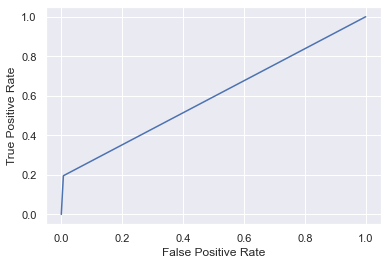

In [47]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

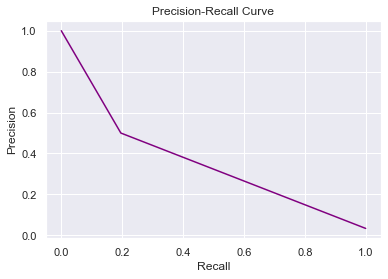

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, lpredict_test)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

<a id='bayes'></a>
### Naive Bayes Model

In [49]:
#scikit page on naive bayes: https://scikit-learn.org/stable/modules/naive_bayes.html

In [50]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_train, y_train)
gpredict_test = gnb_model.predict(X_test)
gpredict_train = gnb_model.predict(X_train)

In [51]:
#fit on training set
fpr, tpr, ths = roc_curve(y_train, gpredict_train)
print("Accuracy:",metrics.accuracy_score(y_train, gpredict_train))
print("TRP/Recall:",metrics.recall_score(y_train, gpredict_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, gpredict_train))
print("F1:",metrics.f1_score(y_train, gpredict_train))

Accuracy: 0.833730522456462
TRP/Recall: 0.8620689655172413
FPR: 0.16720318121567884
Precision: 0.1452081316553727
F1: 0.24855012427506215


In [52]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, gpredict_test)
print("Accuracy:",metrics.accuracy_score(y_test, gpredict_test))
print("TRP/Recall:",metrics.recall_score(y_test, gpredict_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, gpredict_test))
print("F1:",metrics.f1_score(y_test, gpredict_test))

Accuracy: 0.8401759530791789
TRP/Recall: 0.7608695652173914
FPR: 0.15705614567526555
Precision: 0.1446280991735537
F1: 0.24305555555555555


In [53]:
sum(gpredict_test)

242

<font color='red'> The Naive Bayes performs slighly worse than logistic based on the F1 score.</font>

<font color='red'> The Bayes accuracy went down as it over predicted bankruptcy.  Predicting 242 bankrupties when the actual number was 46  </font>

<font color='red'> Recall improved substantial.  We accurately predicted 35 of the 46 bankruptcies.  Much better than the 9 successfully predicted under the logistic.  But the model also suffers from much worse precision, due to the number of FPs the model generates by over-estimating bankruptcies.  The bayes model has 207 false positives versus the 9 under the logistic model </font>

<font color='red'> FPR went up substantial because of the FP issue with this model </font>

<font color='red'> Naive bayes assumes that features make indepedent and equal contirubtions to the outcome.  This is likley not true of this dataset.  First we have seen many variables measure very similiar financial metrics and as such independence is likely violated.  Additionally we anticipate these variables don't equally contribute to bankruptcy.  Intuitively something like tax rate would seem to have substantially less impact on bankruptcy then amount of outstanding liabilities and degree of indebtness </font>

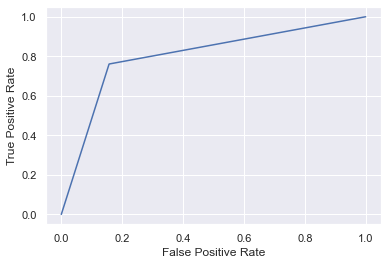

In [54]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

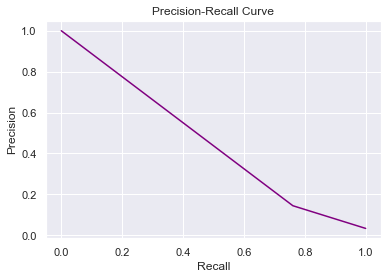

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, gpredict_test)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

<a id='svm_rbf'></a>
### Support Vector Machine Model (RBF)

In [56]:
#scikit page on SVM: https://scikit-learn.org/stable/modules/svm.html

In [57]:
#another SVM support page: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

In [58]:
slin = svm.SVC(kernel='rbf')
rbf = slin.fit(X_train, y_train)

In [59]:
rbf_test = rbf.predict(X_test)
rbf_train = rbf.predict(X_train)

In [60]:
#fit on training set
fpr, tpr, ths = roc_curve(y_train, rbf_train)
print("Accuracy:",metrics.accuracy_score(y_train, rbf_train))
print("TRP/Recall:",metrics.recall_score(y_train, rbf_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, rbf_train))
print("F1:",metrics.f1_score(y_train, rbf_train))

Accuracy: 0.9723189734188817
TRP/Recall: 0.13218390804597702
FPR: 0.0
Precision: 1.0
F1: 0.233502538071066


In [61]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, rbf_test)
print("Accuracy:",metrics.accuracy_score(y_test, rbf_test))
print("TRP/Recall:",metrics.recall_score(y_test, rbf_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, rbf_test))
print("F1:",metrics.f1_score(y_test, rbf_test))

Accuracy: 0.967008797653959
TRP/Recall: 0.021739130434782608
FPR: 0.0
Precision: 1.0
F1: 0.042553191489361694


In [62]:
sum(rbf_test)

1

<font color='red'> The RBF kernel underestimates bankruptcy.  So the accuracy is high, but the recall suffers substantially, as we only predict 1 bankruptcy </font>

<font color='red'> The low recall hurts the model too much giving us our worse F1 score so far </font>

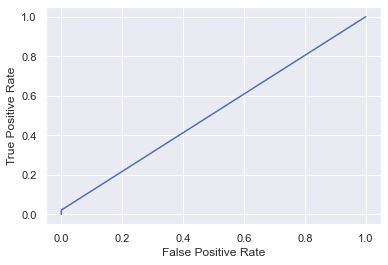

In [63]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

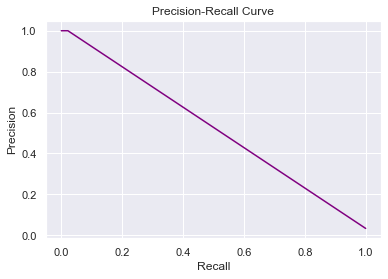

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test, rbf_test)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

<a id='svm_poly'></a>
### Support Vector Machine Model (Poly)

In [65]:
spll = svm.SVC(kernel='poly')
poly = spll.fit(X_train, y_train)

In [66]:
poly_test = poly.predict(X_test)
poly_train = poly.predict(X_train)

In [67]:
#fit on training set
fpr, tpr, ths = roc_curve(y_train, poly_train)
print("Accuracy:",metrics.accuracy_score(y_train, poly_train))
print("TRP/Recall:",metrics.recall_score(y_train, poly_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, poly_train))
print("F1:",metrics.f1_score(y_train, poly_train))

Accuracy: 0.9748854262144822
TRP/Recall: 0.21264367816091953
FPR: 0.0
Precision: 1.0
F1: 0.3507109004739336


In [68]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, poly_test)
print("Accuracy:",metrics.accuracy_score(y_test, poly_test))
print("TRP/Recall:",metrics.recall_score(y_test, poly_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, poly_test))
print("F1:",metrics.f1_score(y_test, poly_test))

Accuracy: 0.969208211143695
TRP/Recall: 0.15217391304347827
FPR: 0.002276176024279211
Precision: 0.7
F1: 0.25


In [69]:
sum(poly_test)

10

<font color='red'> The poly kernel performs better than the RBF kernel, but still has a lower score then the logistic regression</font>

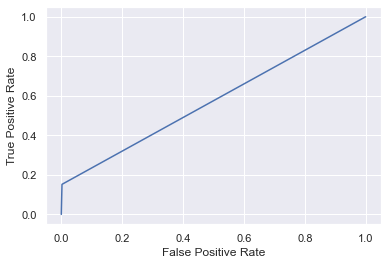

In [70]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

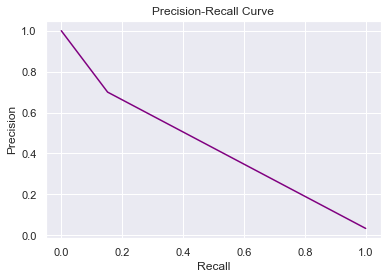

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, poly_test)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

<a id='svm_linear'></a>
### Support Vector Machine Model (Linear)

In [72]:
slin = svm.SVC(kernel='linear')
liner = slin.fit(X_train, y_train)

In [73]:
line_test = liner.predict(X_test)
line_train = liner.predict(X_train)

In [74]:
#fit on training set
fpr, tpr, ths = roc_curve(y_train, line_train)
print("Accuracy:",metrics.accuracy_score(y_train, line_train))
print("TRP/Recall:",metrics.recall_score(y_train, line_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, line_train))
print("F1:",metrics.f1_score(y_train, line_train))

Accuracy: 0.9719523373052246
TRP/Recall: 0.13218390804597702
FPR: 0.0003787161522438932
Precision: 0.92
F1: 0.2311557788944724


In [75]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, line_test)
print("Accuracy:",metrics.accuracy_score(y_test, line_test))
print("TRP/Recall:",metrics.recall_score(y_test, line_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, line_test))
print("F1:",metrics.f1_score(y_test, line_test))

Accuracy: 0.967008797653959
TRP/Recall: 0.13043478260869565
FPR: 0.0037936267071320183
Precision: 0.5454545454545454
F1: 0.21052631578947367


<font color='red'> Our hypertuning shows thats the poly kernal appears to be the best fit amongst the SVM kernals.  Although as pointed out the overall F1 score is better on the logistic regression so we will prefer that model</font>

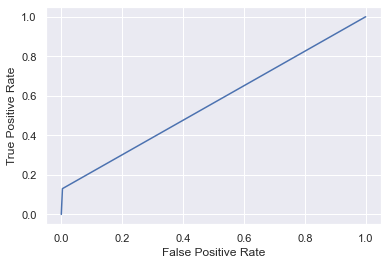

In [76]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

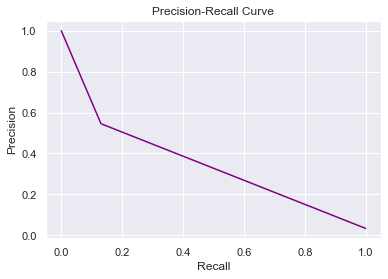

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, line_test)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

# Week 5 <a id=’week5’></a>

<a id='forest'></a>
### Random Forest Classifier - Default Assumptions

<font color='red'> we first just train a random forest model with default assumptions </font>

In [78]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [79]:
rf_test = rf.predict(X_test)
rf_train = rf.predict(X_train)

In [80]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, rf_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_test))
print("TRP/Recall:",metrics.recall_score(y_test, rf_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, rf_test))
print("F1:",metrics.f1_score(y_test, rf_test))

Accuracy: 0.968475073313783
TRP/Recall: 0.17391304347826086
FPR: 0.0037936267071320183
Precision: 0.6153846153846154
F1: 0.2711864406779661


<font color='red'> This produces our best F1 score so far</font>

In [81]:
#looking at parameters of the defaul model to help get an idea of what range we should hypertune in
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [82]:
#looking at max depth of any individual tree
print('Max Depth of any Tree: ',max([estimator.tree_.max_depth for estimator in rf.estimators_]))

Max Depth of any Tree:  19


<a id='forest_hypertuned'></a>
### Random Forest Classifier - Hypertuned

<font color='red'> We now gridsearch for better random forests by hypertuning the # of trees, max feature splits, max depth, and splitting criteria</font>

In [83]:
#building the hypertuning vectors
n_estimators = [100,1000,6819]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(15, 19, num = 4)]
criterion = ['gini','entropy','log_loss']

In [84]:
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'criterion': criterion}

In [85]:
rf_hyper = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, n_iter = 100, cv = 10, n_jobs = -1,scoring='f1')

In [86]:
#compute intensify, so commenting out after intial run.  results are hard coded into next line
#rf_hyper.fit(X_train, y_train)
#print ('Hypertuned Parameters: ', rf_hyper.best_params_, ' \n')

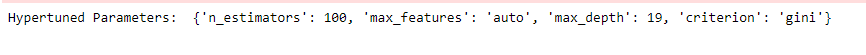

In [87]:
rf_final = RandomForestClassifier(n_estimators = 100, max_features = 'auto', max_depth= 19, criterion='gini') 
rf_final.fit( X_train, y_train) 

RandomForestClassifier(max_depth=19)

In [88]:
rf_final_test = rf_final.predict(X_test)

In [89]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, rf_final_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_final_test))
print("TRP/Recall:",metrics.recall_score(y_test, rf_final_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, rf_final_test))
print("F1:",metrics.f1_score(y_test, rf_final_test))

Accuracy: 0.9699413489736071
TRP/Recall: 0.1956521739130435
FPR: 0.0030349013657056147
Precision: 0.6923076923076923
F1: 0.3050847457627119


<font color='red'> The hypertuned model actually performed slightly worse on the holdout data, so we still prefer the Random Forest Model with default assumptions.  

<a id='gboost'></a>
### Gradient Boosted Trees

<font color='red'> Training the boosted tree with default sklearn assumptions. Default assumptions are a 0.1 learning rate, 100 boosting stages, max node depth of 3, max features equal to number of features, and Friedman MSE criteria </font>

In [90]:
gboost = GradientBoostingClassifier(warm_start=False)
gboost.fit(X_train, y_train)
gboost_test = gboost.predict(X_test)
gboost_train = gboost.predict(X_train)

In [91]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, gboost_test)
print("Accuracy:",metrics.accuracy_score(y_test, gboost_test))
print("TRP/Recall:",metrics.recall_score(y_test, gboost_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, gboost_test))
print("F1:",metrics.f1_score(y_test, gboost_test))

Accuracy: 0.967741935483871
TRP/Recall: 0.34782608695652173
FPR: 0.010622154779969651
Precision: 0.5333333333333333
F1: 0.4210526315789474


<font color='red'> The default Boosted Trees outperforms all other models based on F1 score</font>

In [92]:
gboost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

<a id='hgboost'></a>
### Gradient Boosted Trees - Hypertuned

<font color='red'> Applying a gridsearch technique to hypertune the Boosted Trees</font>

In [93]:
#building the hypertuning vectors
n_estimators = [100,1000,6819]
max_features = ['auto', 'sqrt','log2',None]
max_depth = [1,2,3]
criterion = ['friedman_mse','squared_error','mse']
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'criterion': criterion}

In [94]:
#compute intensify, so commenting out after intial run.  results are hard coded into next line
#gboost_hyper = RandomizedSearchCV(estimator = gboost,param_distributions = random_grid, n_iter = 20, cv = 10, n_jobs = -1,scoring='f1')
#gboost_hyper.fit(X_train, y_train)
#print ('Hypertuned Parameters: ', gboost_hyper.best_params_, ' \n')

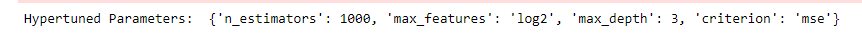

In [95]:
gboost_final = GradientBoostingClassifier(n_estimators = 1000, max_features = 'log2', max_depth= 3, criterion='mse',warm_start=False)
gboost_final.fit(X_train, y_train) 
gboost_final_test = gboost_final.predict(X_test)
gboost_final_train = gboost_final.predict(X_train)
gboost_final.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [96]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, gboost_final_test)
print("Accuracy:",metrics.accuracy_score(y_test, gboost_final_test))
print("TRP/Recall:",metrics.recall_score(y_test, gboost_final_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, gboost_final_test))
print("F1:",metrics.f1_score(y_test, gboost_final_test))

Accuracy: 0.9611436950146628
TRP/Recall: 0.21739130434782608
FPR: 0.012898330804248861
Precision: 0.37037037037037035
F1: 0.27397260273972607


<font color='red'> The hypertuned model doesn't perform better on the validation data, so we revert back to the original hypertuning parameters of the gboost.  This can happen in practice, but likley part of the problem is I am running a pretty limited set of values across which to hypertune.  I am doing this because I am running the gridsearch locally so don't have the compute to run a rigorous gridsearch.  If we expanded the grid we likely would find a hypertuned model that outperforms the original on the holdout data</font>

<a id='etrees'></a>
### Extra Trees - Default Assumptions

<font color='red'> Training extra trees with default sklearn assumptions. Default assumptions are 100 trees, depth increased until leaves are pure, max features equal to number of features, and gini criteria

In [97]:
et = ExtraTreesClassifier(warm_start=False)
et.fit(X_train, y_train)
et_test = et.predict(X_test)
et_train = et.predict(X_train)

In [98]:
#fit on training data
fpr, tpr, ths = roc_curve(y_train, et_train)
print("Accuracy:",metrics.accuracy_score(y_train, et_train))
print("TRP/Recall:",metrics.recall_score(y_train, et_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, et_train))
print("F1:",metrics.f1_score(y_train, et_train))

Accuracy: 1.0
TRP/Recall: 1.0
FPR: 0.0
Precision: 1.0
F1: 1.0


In [99]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, et_test)
print("Accuracy:",metrics.accuracy_score(y_test, et_test))
print("TRP/Recall:",metrics.recall_score(y_test, et_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, et_test))
print("F1:",metrics.f1_score(y_test, et_test))

Accuracy: 0.968475073313783
TRP/Recall: 0.1956521739130435
FPR: 0.004552352048558422
Precision: 0.6
F1: 0.29508196721311475


In [100]:
et.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<font color='red'> The extra trees model overfits the data.  Performing really well on the training data, but underperforming the gradient boosted trees on the holdout set

<a id='hetrees'></a>
### Extra Trees - Hypertuned

In [101]:
#building the hypertuning vectors
n_estimators = [100,1000,6819]
max_features = ['auto','sqrt','log2',None]
max_depth = [None,3,5]
criterion = ['gini','entropy']
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'criterion': criterion}

In [102]:
#compute intensify, so commenting out after intial run.  results are hard coded into next line
#et_hyper = RandomizedSearchCV(estimator = et,param_distributions = random_grid, n_iter = 10, cv = 5, n_jobs = -1,scoring='f1')
#et_hyper.fit(X_train, y_train)
#print ('Hypertuned Parameters: ', et_hyper.best_params_, ' \n')

In [103]:
et_final = ExtraTreesClassifier(n_estimators = 100, max_features = None, max_depth= None, criterion='entropy',warm_start=False)
et_final.fit(X_train, y_train) 
et_final_test = et_final.predict(X_test)
et_final_train = et_final.predict(X_train)
et_final.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [104]:
#fit on training data
fpr, tpr, ths = roc_curve(y_train, et_final_train)
print("Accuracy:",metrics.accuracy_score(y_train, et_final_train))
print("TRP/Recall:",metrics.recall_score(y_train, et_final_train))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_train, et_final_train))
print("F1:",metrics.f1_score(y_train, et_final_train))

Accuracy: 1.0
TRP/Recall: 1.0
FPR: 0.0
Precision: 1.0
F1: 1.0


In [105]:
#fit on validation data
fpr, tpr, ths = roc_curve(y_test, et_final_test)
print("Accuracy:",metrics.accuracy_score(y_test, et_final_test))
print("TRP/Recall:",metrics.recall_score(y_test, et_final_test))
print("FPR:",fpr[1])
print("Precision:",metrics.precision_score(y_test, et_final_test))
print("F1:",metrics.f1_score(y_test, et_final_test))

Accuracy: 0.9655425219941349
TRP/Recall: 0.15217391304347827
FPR: 0.006069802731411229
Precision: 0.4666666666666667
F1: 0.22950819672131148


<font color='red'> The hypertuned model is still overfitting

<a id='kaggle'></a>
###  Notes on Kaggle Submission

<font color='red'> Note that on Kaggle this was not a competition, so there is no evaluation data to use.  As a result, I did not submit any models for Kaggle evaluations.  However we did make predictions on our holdout data.  And that is what we used to evaluate our relative model performance (via F1 scores)

<a id='final'></a>
###  Final Model Selection

<font color='red'> We evaluated several models to try to predict bankruptcy.  A number of models including SVM, logistic regression, naive bayes, random forest, grandient boosed trees, and extra trees were used.  Models were calibrated to test data.  This test data consisted of 80% of the original data.  Once trained, the models where ran on the remaining data (holdout set) and bankruptcy predictions were made.  The results were compared against actual results to compare the effectiveness of each model.  The model with the highest F1 score was choosen as the final model.  The F1 score is an accuracy measure that balances two seperate meausres of model accuracy (Recal and Precision).  Our final model, based on the best F1 score, is the gradient boosted trees.

In [164]:
#fit a random forest on our Bankruptcy data.  Fitting to 80% training data
rf = RandomForestClassifier(warm_start=False)
rf.fit(X_train, y_train) #train
rf_predict = rf.predict(X_test) #predict bankruptcy on holdout data

In [165]:
#apply a monotonic transformation to the explanatory variables
X_train_transformed = X_train.transform(lambda x: x+1)
X_test_transformed = X_test.transform(lambda x: x+1)

In [166]:
#fit a new random forest to the transfored data
rf_T = RandomForestClassifier(warm_start=False)
rf_T.fit(X_train_transformed, y_train)
rf_T_predict =rf_T.predict(X_test_transformed)

In [167]:
#do the two models made identical predictions
(rf_predict == rf_T_predict).all()

False